In [5]:
import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Importing our own functions
import standardize_datasets
from utils import confusion_matrix_improved

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm

In [2]:
from pympler import summary, muppy

In [3]:
allObjects = muppy.get_objects()
sum1 = summary.summarize(allObjects)
summary.print_(sum1)


                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |       32441 |      9.52 MB
                                str |       69976 |      9.32 MB
                               code |       20798 |      3.54 MB
                               type |        3038 |      2.82 MB
                               list |       10741 |      1.07 MB
                              tuple |       19247 |      1.06 MB
                                set |         970 |    652.86 KB
                                int |       21519 |    604.97 KB
                             method |        5340 |    333.75 KB
                            weakref |        4135 |    290.74 KB
                        abc.ABCMeta |         282 |    287.84 KB
                function (__init__) |        1701 |    225.91 KB
  traitlets.traitlets.MetaHasTraits |         214 |    214.12 KB
                  getset_

In [6]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_embedding = hub.load(module_url)

2023-04-23 12:42:15.562059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 12:42:15.562181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-23 12:42:18.651456: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-23 12:42:18.718032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Get the dataset

In [7]:
df = pd.read_csv('data/train_clean.csv')
df.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [10]:
len(X_train), len(X_test)

(15353, 3839)

# Classification using similarity between sentence embeddings

In [11]:
false_sent = np.array(X_train[y_train == 0].values[:1000])
true_sent = np.array(X_train[y_train == 1].values[:1000])

false_sent_embeddings = model_embedding(false_sent)
true_sent_embeddings = model_embedding(true_sent)

X_test = X_test.values[:200]
y_test = y_test.values[:200]

2023-04-23 12:42:40.222812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
class SimilarityModel:
    fit = False
    true_sent = None
    false_sent = None
    model_embedding = None

    def __init__(self, _model_embedding):
        self.model_embedding = _model_embedding
        pass

    def fit(self, true_sent, false_sent):
        self.true_sent = true_sent
        self.false_sent = false_sent
        self.fit = True
    
    def predict(self, sent):
        if not self.fit:
            raise Exception("Model not fitted")
        
        sent_embeddings = model_embedding(sent)
        false_sim = np.inner(model_embedding(self.false_sent), sent_embeddings)
        true_sim = np.inner(model_embedding(self.true_sent), sent_embeddings)
        # For each return 1 if true_sim > false_sim else 0
        return np.mean(true_sim, axis=0) > np.mean(false_sim, axis=0)

In [13]:
model = SimilarityModel(model_embedding)

In [14]:
model.fit(true_sent, false_sent)

In [15]:
def performance(model, tfidf_test, y_test):
    y_pred = model.predict(tfidf_test)
    confusion_matrix_improved(y_test, y_pred)
    plt.title(f'Confusion matrix. Accuracy: {accuracy_score(y_test, y_pred):.3f}')

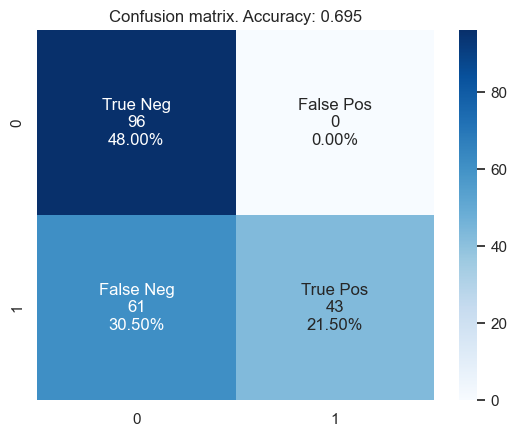

In [16]:
performance(model, X_test, y_test)